In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision as tv
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import imageio
from PIL import Image
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont
device = 'cuda'

In [174]:


def pixel_noise_mask(img, p=0.5):
    assert p > 0 and p < 1
    mask = torch.rand(512, 512)
    img[:, :, mask<p] = 0
    mask = mask > p
    mask = mask.repeat(1,3,1,1)
    return img, mask

def pixel_text_mask(for_image, sz=20, position=(128, 128), text='hello world'):

    """
    refer from:
    https://github.com/DmitryUlyanov/deep-image-prior/blob/master/utils/inpainting_utils.py

    """
    assert len(text) == len(position)
    font_fname = 'FreeSansBold.ttf'
    font_size = sz
    font = ImageFont.truetype(font_fname, font_size)
    img_mask = Image.fromarray(np.array(for_image)*0+255)
    
    binary_mask_temp = np.array(img_mask)
    binary_masks = np.zeros_like(binary_mask_temp, dtype=np.float32)
    binary_masks += 1.0
    binary_masks[binary_mask_temp<254] -= 1.0
    for i in range(len(text)):
        img_mask = Image.fromarray(np.array(for_image)*0+255)
        draw = ImageDraw.Draw(img_mask)
        draw.text(position[i], text[i], font=font, fill='rgb(0, 0, 0)')
        binary_mask_temp = np.array(img_mask)
        binary_mask = np.zeros_like(binary_mask_temp, dtype=np.float32)
        binary_mask += 1.0
        binary_mask[binary_mask_temp<254] -= 1.0
        binary_masks = np.multiply(binary_masks, binary_mask)
    
    binary_masks = binary_masks.astype(np.uint8)
    binary_masks = Image.fromarray(binary_masks)
    corrupted_image = np.multiply(for_image, binary_masks)
    corrupted_image = corrupted_image.astype(np.uint8)
    corrupted_image = Image.fromarray(corrupted_image)
    
    return corrupted_image,binary_masks

In [3]:
class DIP_model(nn.Module):
    def __init__(self):
        super(Hourglass, self).__init__()

        self.leaky_relu = nn.LeakyReLU()

        self.d_conv_1 = nn.Conv2d(2, 8, 5, stride=2, padding=2)
        self.d_bn_1 = nn.BatchNorm2d(8)
        self.d_conv_2 = nn.Conv2d(8, 16, 5, stride=2, padding=2)
        self.d_bn_2 = nn.BatchNorm2d(16)
        self.d_conv_3 = nn.Conv2d(16, 32, 5, stride=2, padding=2)
        self.d_bn_3 = nn.BatchNorm2d(32)
        self.s_conv_3 = nn.Conv2d(32, 4, 5, stride=1, padding=2)
        self.d_conv_4 = nn.Conv2d(32, 64, 5, stride=2, padding=2)
        self.d_bn_4 = nn.BatchNorm2d(64)
        self.s_conv_4 = nn.Conv2d(64, 4, 5, stride=1, padding=2)
        self.d_conv_5 = nn.Conv2d(64, 128, 5, stride=2, padding=2)
        self.d_bn_5 = nn.BatchNorm2d(128)
        self.s_conv_5 = nn.Conv2d(128, 4, 5, stride=1, padding=2)
        self.d_conv_6 = nn.Conv2d(128, 256, 5, stride=2, padding=2)
        self.d_bn_6 = nn.BatchNorm2d(256)

        self.u_deconv_5 = nn.ConvTranspose2d(256, 124, 4, stride=2, padding=1)
        self.u_bn_5 = nn.BatchNorm2d(128)
        self.u_deconv_4 = nn.ConvTranspose2d(128, 60, 4, stride=2, padding=1)
        self.u_bn_4 = nn.BatchNorm2d(64)
        self.u_deconv_3 = nn.ConvTranspose2d(64, 28, 4, stride=2, padding=1)
        self.u_bn_3 = nn.BatchNorm2d(32)
        self.u_deconv_2 = nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1)
        self.u_bn_2 = nn.BatchNorm2d(16)
        self.u_deconv_1 = nn.ConvTranspose2d(16, 8, 4, stride=2, padding=1)
        self.u_bn_1 = nn.BatchNorm2d(8)
        self.out_deconv = nn.ConvTranspose2d(8, 3, 4, stride=2, padding=1)
        self.out_bn = nn.BatchNorm2d(3)

    def forward(self, noise):
        down_1 = self.d_conv_1(noise)
        down_1 = self.d_bn_1(down_1)
        down_1 = self.leaky_relu(down_1)
        down_2 = self.d_conv_2(down_1)
        down_2 = self.d_bn_2(down_2)
        down_2 = self.leaky_relu(down_2)
        down_3 = self.d_conv_3(down_2)
        down_3 = self.d_bn_3(down_3)
        down_3 = self.leaky_relu(down_3)
        skip_3 = self.s_conv_3(down_3)
        down_4 = self.d_conv_4(down_3)
        down_4 = self.d_bn_4(down_4)
        down_4 = self.leaky_relu(down_4)
        skip_4 = self.s_conv_4(down_4)
        down_5 = self.d_conv_5(down_4)
        down_5 = self.d_bn_5(down_5)
        down_5 = self.leaky_relu(down_5)
        skip_5 = self.s_conv_5(down_5)
        down_6 = self.d_conv_6(down_5)
        down_6 = self.d_bn_6(down_6)
        down_6 = self.leaky_relu(down_6)

        up_5 = self.u_deconv_5(down_6)
        up_5 = torch.cat([up_5, skip_5], 1)
        up_5 = self.u_bn_5(up_5)
        up_5 = self.leaky_relu(up_5)
        up_4 = self.u_deconv_4(up_5)
        up_4 = torch.cat([up_4, skip_4], 1)
        up_4 = self.u_bn_4(up_4)
        up_4 = self.leaky_relu(up_4)
        up_3 = self.u_deconv_3(up_4)
        up_3 = torch.cat([up_3, skip_3], 1)
        up_3 = self.u_bn_3(up_3)
        up_3 = self.leaky_relu(up_3)
        up_2 = self.u_deconv_2(up_3)
        up_2 = self.u_bn_2(up_2)
        up_2 = self.leaky_relu(up_2)
        up_1 = self.u_deconv_1(up_2)
        up_1 = self.u_bn_1(up_1)
        up_1 = self.leaky_relu(up_1)
        out = self.out_deconv(up_1)
        out = self.out_bn(out)
        out = nn.Sigmoid()(out)

        return out

# Denoising

In [22]:

lr = 1e-2 # learning rate
denoise_model = DIP_model()
denoise_model.to(device)
loss_func = nn.MSELoss() # loss function
optimizer = optim.Adam(denoise_model.parameters(), lr=lr)

In [14]:

images = []
losses = []
to_tensor = tv.transforms.ToTensor()
denoise_img = torch.Tensor(np.mgrid[:512, :512]).unsqueeze(0).to(device) / 512

img = Image.open('lenna_ori.png')
input_img  = to_tensor(img).unsqueeze(0)
corrupt_img, noise_mask = pixel_noise_mask(input_img, 0.8)
noise_mask = noise_mask.to(device)
corrupt_img = corrupt_img.to(device)
demo_corrupt = np.array(corrupt_img[0].cpu().detach().permute(1,2,0)*255, np.uint8)




Iteration: 1 Loss: 0.0187560


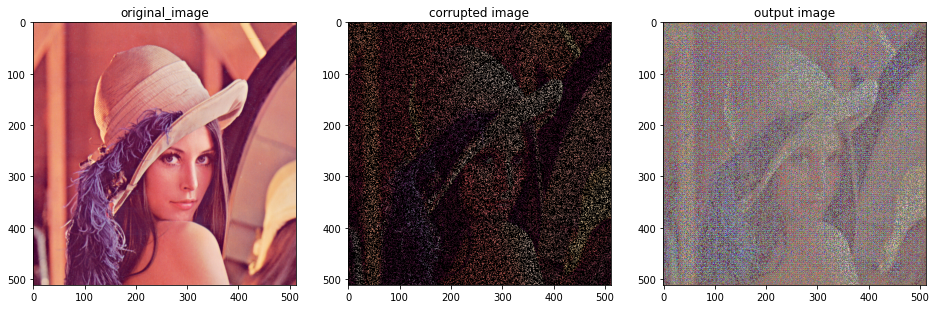

Iteration: 10 Loss: 0.0090065


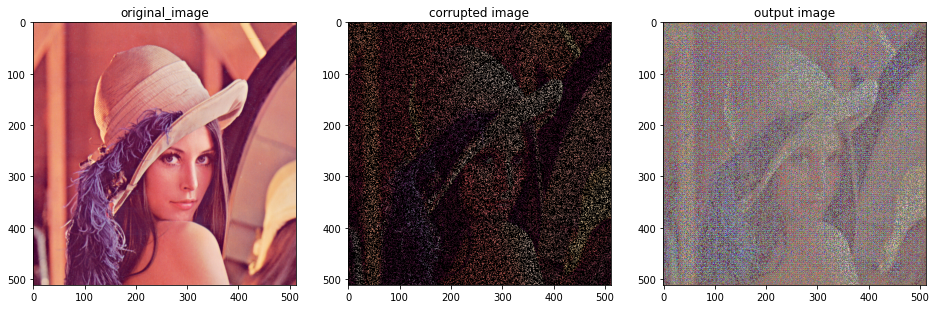

Iteration: 100 Loss: 0.0054992


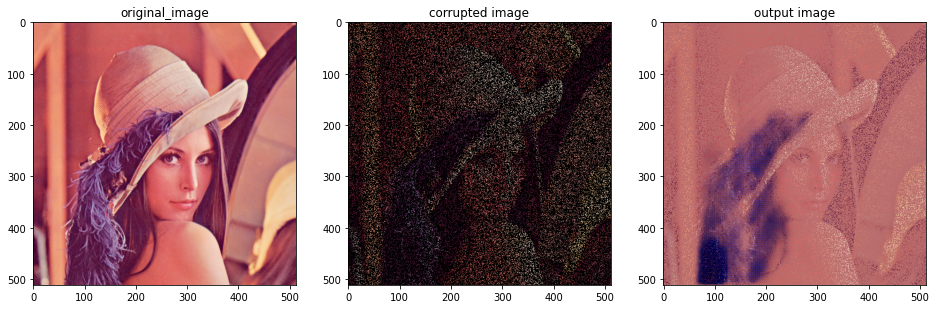

Iteration: 400 Loss: 0.0002572


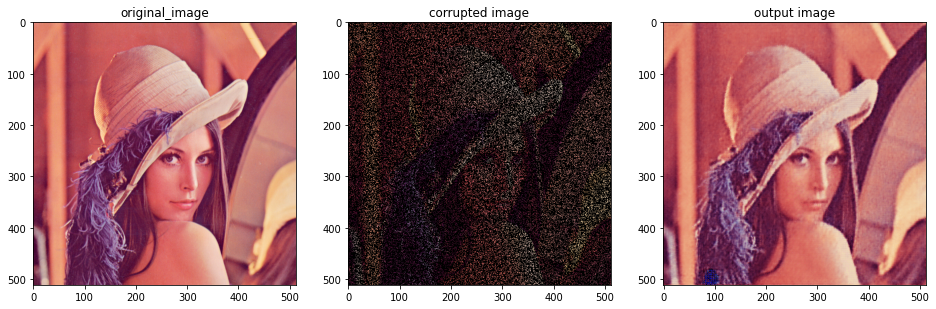

Iteration: 1000 Loss: 0.0001219


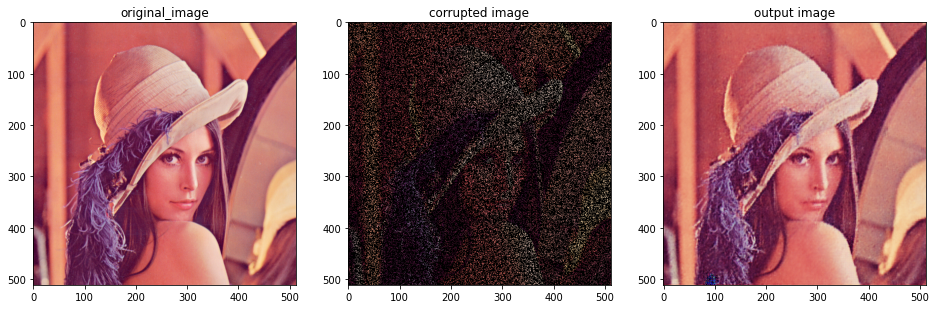

Iteration: 2500 Loss: 0.0000893


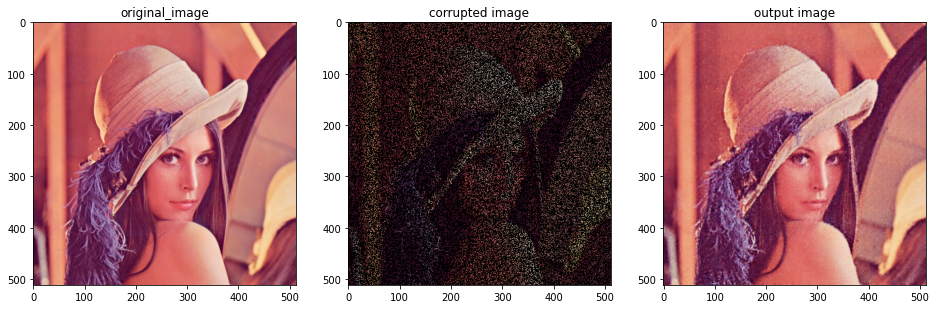

Iteration: 4000 Loss: 0.0000822


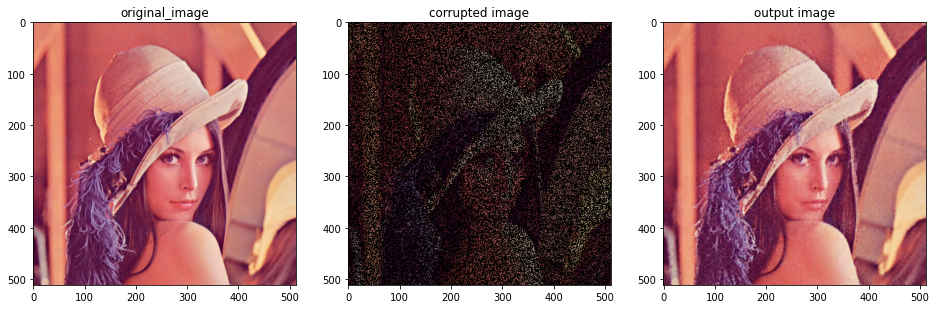

In [15]:
show_list = [1,10, 100, 400, 1000, 2500, 4000]
# training 
for i in range(4000):
    optimizer.zero_grad()
    output_img = denoise_model(denoise_img)
    loss = loss_func(corrupt_img, output_img*noise_mask)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    if (i+1)%25 == 0 or i==0:
        with torch.no_grad():
            out = corrupt_img + output_img * ~noise_mask
            out = out[0].cpu().detach().permute(1,2,0)*255
            out = np.array(out, np.uint8)
            images.append(out)
    if i+1 in show_list:
        print('Iteration: {} Loss: {:.07f}'.format(i+1, losses[-1]))
        fig = plt.figure(figsize=(16,10))
        ax1 = fig.add_subplot(1,3,1)
        ax1.set_title('original_image')
        ax1.imshow(img)
        ax2 = fig.add_subplot(1,3,2)
        ax2.set_title('corrupted image')
        
        ax2.imshow(Image.fromarray(demo_corrupt))
        ax3 = fig.add_subplot(1,3,3)
        ax3.set_title('output image')
        ax3.imshow(Image.fromarray(images[-1]))
        plt.show()
    
        

# Text Inpainting

In [175]:

lr = 1e-2 #learning rate
inpaint_model = DIP_model() 
inpaint_model.to(device)
loss_func = nn.MSELoss() # loss function
optimizer = optim.Adam(inpaint_model.parameters(), lr=lr)

In [176]:
images = []
losses = []
to_tensor = tv.transforms.ToTensor()


x = Image.open('barbara.jpg')
corrupt_img, text_mask =  pixel_text_mask(np.array(x), sz=30, position=[(128, 128),(250,300)], 
                                        text=['Noct068','Inpainting'])
corrupt_img= to_tensor(corrupt_img).unsqueeze(0)

text_mask = to_tensor(text_mask).unsqueeze(0).bool()
corrupt_img = corrupt_img.to(device)
text_mask = text_mask.to(device)
demo_corrupt = np.array(corrupt_img[0].cpu().detach().permute(1,2,0)*255, np.uint8)
output_img = torch.Tensor(np.mgrid[:512, :512]).unsqueeze(0) / 512
output_img=output_img.to(device)


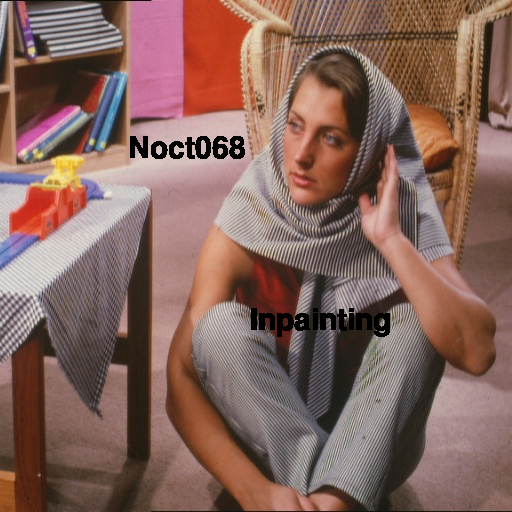

In [177]:
# Corrupt Image

Image.fromarray(demo_corrupt)

Iteration: 1 Loss: 0.0877856


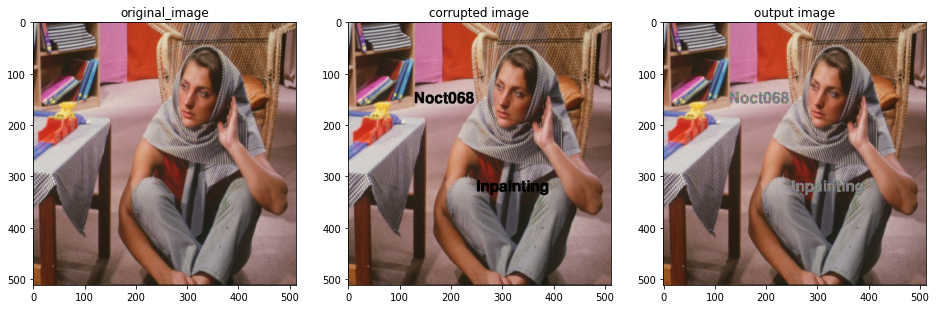

Iteration: 10 Loss: 0.0448801


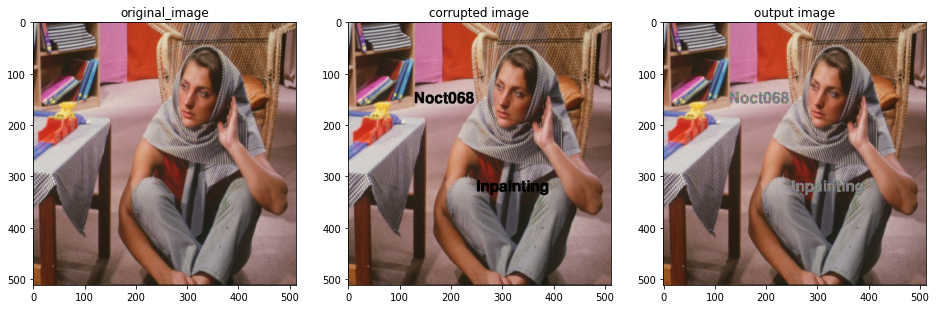

Iteration: 100 Loss: 0.0268970


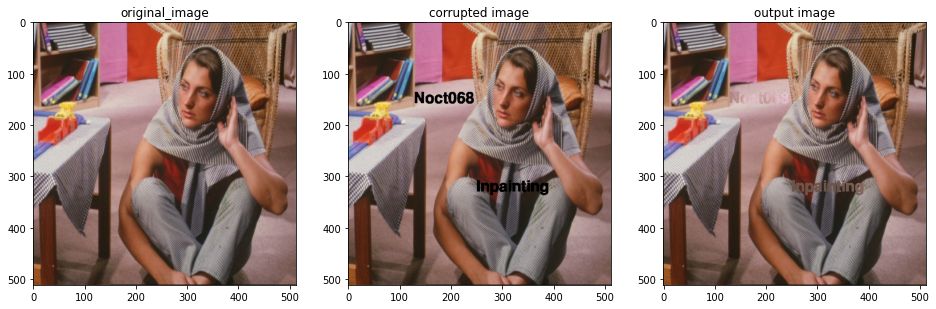

Iteration: 400 Loss: 0.0029608


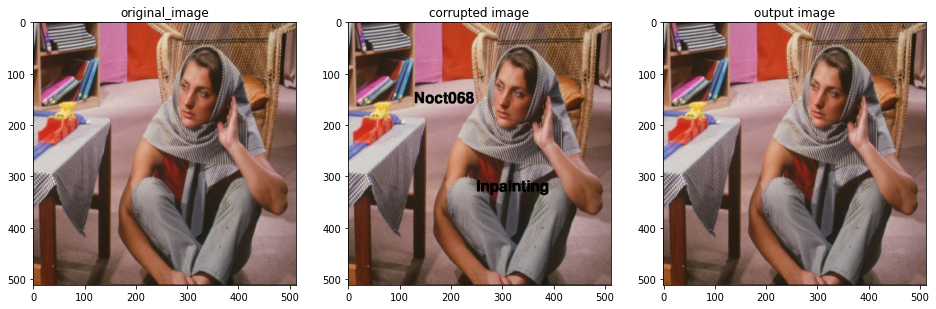

Iteration: 1000 Loss: 0.0019048


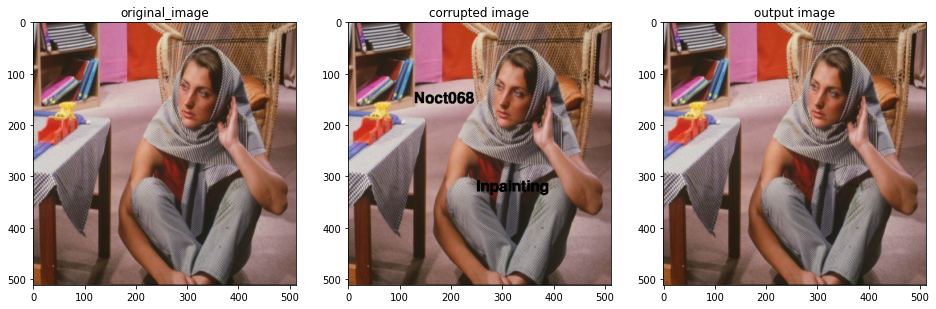

Iteration: 2500 Loss: 0.0017575


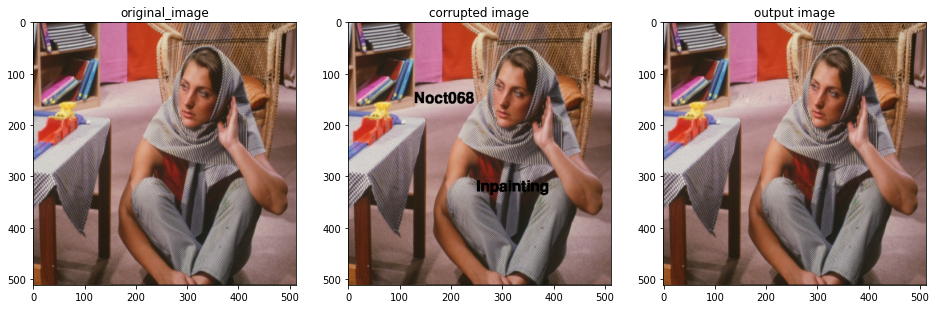

Iteration: 4000 Loss: 0.0011197


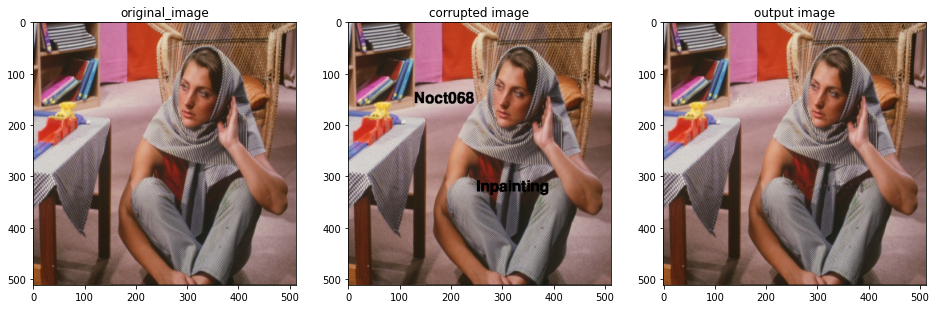

In [178]:
for i in range(4000):
    optimizer.zero_grad()
    y = inpaint_model(output_img)
    loss = mse(corrupt_img, y*text_mask)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    if (i+1)%25 == 0 or i==0:
        with torch.no_grad():
            out = corrupt_img + y * ~text_mask
            out = out[0].cpu().detach().permute(1,2,0)*255
            out = np.array(out, np.uint8)
            images.append(out)
    
    if i+1 in show_list:
        print('Iteration: {} Loss: {:.07f}'.format(i+1, losses[-1]))
        fig = plt.figure(figsize=(16,10))
        ax1 = fig.add_subplot(1,3,1)
        ax1.set_title('original_image')
        ax1.imshow(img)
        ax2 = fig.add_subplot(1,3,2)
        ax2.set_title('corrupted image')  
        ax2.imshow(Image.fromarray(demo_corrupt))
        ax3 = fig.add_subplot(1,3,3)
        ax3.set_title('output image')
        ax3.imshow(Image.fromarray(images[-1]))
        plt.show()

In [180]:
# Save final image

plt.imsave('inpainting-output.jpg', out)
plt.imsave('corrupted-image.jpg', x[0].cpu().detach().permute(1,2,0).numpy())

# Plotting losses during training

plt.plot(losses)

# GIF 
imageio.mimsave('progress.gif', images)
